## Introduction to sentiment analysis

Sentiment analysis is an NLP technique that identifies the polarity of text, labeling it as positive, negative, or neutral.
For example, the tweet

>"@usyd.sudata I hate your coffee catchtups"
>
would be tagged as "Negative," while

>"@usyd.sudata I've sent you a DM"
>
would be "Neutral, and
>"Thanks to @usyd.sudata for running the best datathon ever"
>

would be "Positive."

This method processes large-scale data in real-time, making it easy to analyze tweets, reviews, or support tickets automatically, providing insights for data-driven decisions and automating tasks.

Common applications include:

- Analyzing social media mentions to track brand sentiment.
- Reviewing feedback to understand customer preferences.
- Flagging support tickets to address issues before they lead to churn.


## Getting Started

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import json

# Styling
color_pal = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-colorblind')

# Warnings control
import warnings
warnings.filterwarnings('ignore')


We'll start by using a pretrained model that is specifically trained on tweets.

Copy and paste this code and run it below:

```!pip install -q -y transformers, emoji==0.6.0```

In [2]:
from transformers import pipeline

The following code will take ~2-3 minutes to run as it has to download a model.

In [3]:
sentiment_pipeline = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis", device = -1)

Ensure you are in the correct directory

In [4]:
os.getcwd()

'/Users/lyn/Desktop/datathon2_sudata_2024'

In [5]:
tweet_path = Path('./tweet/') # Update your path here
data_path = Path('./price/') # Update your path here

Lets start by getting one day's worth of tweets and analysing the sentiment.

In [6]:
day = '2014-01-01'
file_path = tweet_path / 'AMZN' / day

In [7]:
data = []
with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))
tweet_df = pd.DataFrame(data)

In [8]:
tweet_df

,text,created_at,user_id_str
0,"[apple, screwed, up, big, time, URL, $, amzn, ...",Wed Jan 01 15:01:12 +0000 2014,23669783


In [9]:
" ".join(tweet_df['text'].iloc[0])

'apple screwed up big time URL $ amzn $ aapl'

In [10]:
sentiment_pipeline(" ".join(tweet_df['text'].iloc[0]))

[{'label': 'NEG', 'score': 0.9749121069908142}]

In [11]:
res = sentiment_pipeline(" ".join(tweet_df['text'].iloc[0]))
pd.Series(res)

0    {'label': 'NEG', 'score': 0.9749121069908142}
dtype: object

In [12]:
def analyze_sentiment(text_tokens_list):
    # for each row in column, join the text tokens together into a single string
    texts = [' '.join(text_tokens) for text_tokens in text_tokens_list]
    # apply the sentiment analysis to the entire list
    results = sentiment_pipeline(texts)
    # extract labels and scores for each result
    sentiments = [(res['label'], res['score']) for res in results]

    return sentiments

In [13]:
sentiment_df = pd.DataFrame(analyze_sentiment(tweet_df['text']), columns=['sentiment', 'score'])

tweet_df = pd.concat([tweet_df, sentiment_df], axis=1)

In [14]:
tweet_df.head(5)

,text,created_at,user_id_str,sentiment,score
0,"[apple, screwed, up, big, time, URL, $, amzn, ...",Wed Jan 01 15:01:12 +0000 2014,23669783,NEG,0.974912


## Getting the Majority Sentiment

Since we have multiple tweets on a given day, lets find a way to aggregate them and determine an overall sentiment for the day. We can start by trying the most frequent sentiment.



In [15]:
most_frequent_sentiment = tweet_df['sentiment'].mode().values.flatten()[0]

In [16]:
most_frequent_sentiment

'NEG'

Most of the time, the most frequent sentiment will be neutral, which is not very helpful. Lets try to only use positive / negative sentiments instead.

In [17]:
def determine_sentiment(sentiments):
    # Count occurrences of "POS" and "NEG"
    positive_count = sentiments.value_counts().get('POS', 0)
    negative_count = sentiments.value_counts().get('NEG', 0)

    # Logic to decide the final sentiment
    if positive_count > negative_count:
        return 'POS'
    elif positive_count < negative_count:
        return 'NEG'
    else:
        return 'NEU'

In [18]:
tweet_df['sentiment'].value_counts()

sentiment
NEG    1
Name: count, dtype: int64

In [19]:
determine_sentiment(tweet_df['sentiment'])

'NEG'

### Getting the Majority Sentiment for all days

In [20]:
stock = 'AMZN'
stock_path = tweet_path / stock

In [21]:
# gets list of dates in this dir
files = [file.stem for file in stock_path.iterdir()]
files[:5]

['2014-10-14', '2015-06-20', '2015-02-10', '2015-05-07', '2015-01-08']

In [22]:
def get_sentiment(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))

    tweet_df = pd.DataFrame(data)
    tweet_date = file_path.stem

    # Apply sentiment analysis to the 'text' column and get all sentiments
    sentiments = [item[0] for item in analyze_sentiment(tweet_df['text'])]
    tweet_df['sentiment'] = sentiments

    sentiment = determine_sentiment(tweet_df['sentiment'])

    # Return the date and majority sentiment as a dictionary or other format
    return {'Date': str(tweet_date), 'Sentiment': sentiment}

In [23]:
get_sentiment(stock_path / files[3])

{'Date': '2015-05-07', 'Sentiment': 'POS'}

In [24]:
all_sentiments = []
# Adds a progess bar for all the sentiments
# This will take some time # 1-2 minutes
for file in tqdm(files, "Processing all files"):
    file_path = stock_path / file
    try:
        result = get_sentiment(file_path)
        all_sentiments.append(result)
    except:
        print(f"Sentiment parsing failed for {file_path}")

Processing all files: 100%|██████████| 671/671 [07:09<00:00,  1.56it/s]


In [25]:
all_sentiments[:5]

[{'Date': '2014-10-14', 'Sentiment': 'NEG'},
 {'Date': '2015-06-20', 'Sentiment': 'POS'},
 {'Date': '2015-02-10', 'Sentiment': 'NEG'},
 {'Date': '2015-05-07', 'Sentiment': 'POS'},
 {'Date': '2015-01-08', 'Sentiment': 'NEU'}]

### Appending result to stock prices, and visualising

In [26]:
data_path = Path('./price/AMZN.csv') # Update your path here
df = pd.read_csv(data_path, header=0)

In [27]:
sentiment_df = pd.DataFrame(all_sentiments)

In [28]:
sentiment_df.head()

,Date,Sentiment
0,2014-10-14,NEG
1,2015-06-20,POS
2,2015-02-10,NEG
3,2015-05-07,POS
4,2015-01-08,NEU


In [29]:
sentiment_df = sentiment_df.sort_values('Date')

In [30]:
sentiment_df.set_index('Date', inplace=True)
sentiment_df.index = pd.to_datetime(sentiment_df.index)

In [31]:
sentiment_df

,Sentiment
Date,
2014-01-01,NEG
2014-01-02,NEU
2014-01-03,POS
2014-01-05,NEG
2014-01-06,NEU
...,...
2015-12-27,NEU
2015-12-28,POS
2015-12-29,POS


In [32]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

In [33]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-04,248.270004,251.000000,244.660004,247.880005,247.880005,3950800
2012-09-05,247.610001,248.610001,245.300003,246.220001,246.220001,2652600
2012-09-06,248.229996,252.699997,247.199997,251.380005,251.380005,5361400
2012-09-07,253.850006,259.420013,253.520004,259.140015,259.140015,5029500
2012-09-10,259.000000,260.000000,256.820007,257.089996,257.089996,2567200
...,...,...,...,...,...,...
2017-08-28,946.539978,953.000000,942.250000,946.020020,946.020020,2596700
2017-08-29,940.000000,956.000000,936.330017,954.059998,954.059998,2874300
2017-08-30,958.440002,969.409973,956.909973,967.590027,967.590027,2904600


In [34]:
combined_df = pd.merge(df, sentiment_df, left_index=True, right_index=True, how='outer')

In [35]:
combined_df.head()

,Open,High,Low,Close,Adj Close,Volume,Sentiment
Date,,,,,,,
2012-09-04,248.270004,251.000000,244.660004,247.880005,247.880005,3950800.0,NaN
2012-09-05,247.610001,248.610001,245.300003,246.220001,246.220001,2652600.0,NaN
2012-09-06,248.229996,252.699997,247.199997,251.380005,251.380005,5361400.0,NaN
2012-09-07,253.850006,259.420013,253.520004,259.140015,259.140015,5029500.0,NaN
2012-09-10,259.000000,260.000000,256.820007,257.089996,257.089996,2567200.0,NaN


In [36]:
combined_df['Sentiment'].value_counts()

Sentiment
POS    345
NEU    243
NEG     83
Name: count, dtype: int64

In [37]:
combined_df

,Open,High,Low,Close,Adj Close,Volume,Sentiment
Date,,,,,,,
2012-09-04,248.270004,251.000000,244.660004,247.880005,247.880005,3950800.0,NaN
2012-09-05,247.610001,248.610001,245.300003,246.220001,246.220001,2652600.0,NaN
2012-09-06,248.229996,252.699997,247.199997,251.380005,251.380005,5361400.0,NaN
2012-09-07,253.850006,259.420013,253.520004,259.140015,259.140015,5029500.0,NaN
2012-09-10,259.000000,260.000000,256.820007,257.089996,257.089996,2567200.0,NaN
...,...,...,...,...,...,...,...
2017-08-28,946.539978,953.000000,942.250000,946.020020,946.020020,2596700.0,NaN
2017-08-29,940.000000,956.000000,936.330017,954.059998,954.059998,2874300.0,NaN
2017-08-30,958.440002,969.409973,956.909973,967.590027,967.590027,2904600.0,NaN


Text(0, 0.5, 'Opening Price')

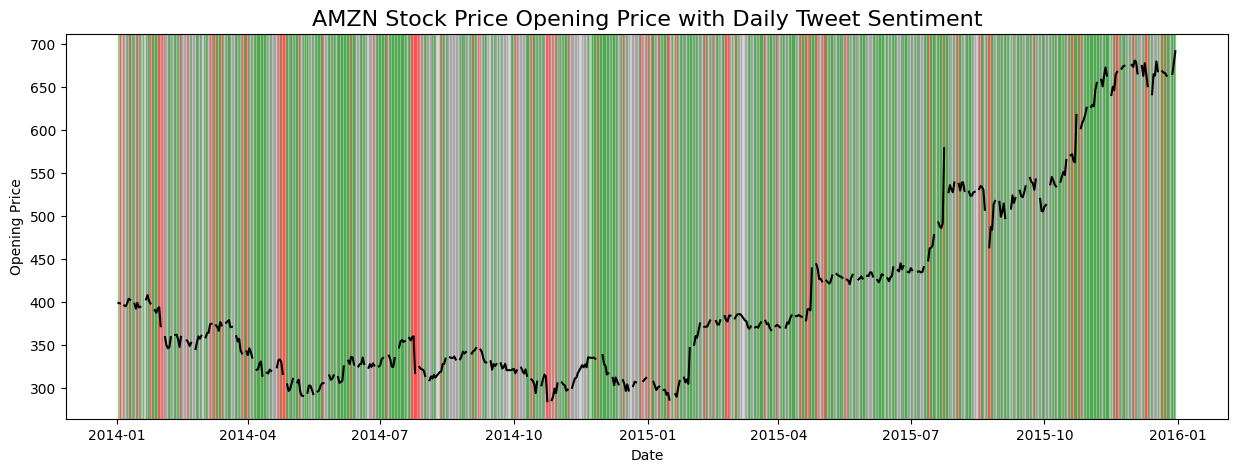

In [38]:
df = combined_df.loc[(combined_df.index > '2014-01-01') & (combined_df.index < '2015-12-31')]


fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df.index, df['Open'], label='Opening Price', color='black')

for i in range(1, len(df)):
    prev_date = df.index[i - 1]
    curr_date = df.index[i]

    # Determine the sentiment color for the region
    color_map = {'POS': 'green', 'NEG': 'red', 'NEU': 'gray', np.nan: 'gray'}

    sentiment = df['Sentiment'].iloc[i]
    color = color_map.get(sentiment, 'gray')

    # Use ax.axhspan to color the region between two dates
    ax.axvspan(prev_date, curr_date, color=color, alpha=0.3)

ax.set_title('AMZN Stock Price Opening Price with Daily Tweet Sentiment', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Opening Price')

In [39]:
def majority_sentiment(sentiments):
    pos_count = (sentiments == 'POS').sum()
    neg_count = (sentiments == 'NEG').sum()
    neu_count = (sentiments == 'NEU').sum()

    if pos_count > neg_count and pos_count > neu_count:
        return 'POS'
    elif neg_count > pos_count and neg_count > neu_count:
        return 'NEG'
    else:
        return 'NEU'

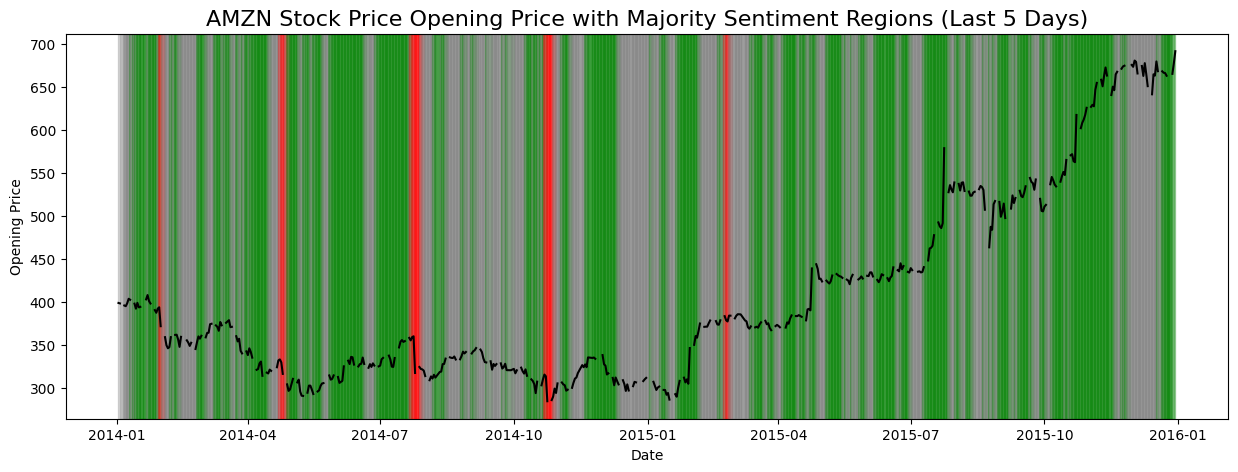

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df.index, df['Open'], label='Opening Price', color='black')

for i in range(4, len(df)):  # Start at 4 since we need to look back 4 days
    prev_date = df.index[i - 4]  #
    curr_date = df.index[i]


    sentiment_last_five_days = df['Sentiment'].iloc[i-4:i+1]

    # Determine the majority sentiment over the last 5 days
    majority = majority_sentiment(sentiment_last_five_days)


    color = color_map.get(majority, 'gray')
    ax.axvspan(prev_date, curr_date, color=color, alpha=0.3)


ax.set_title('AMZN Stock Price Opening Price with Majority Sentiment Regions (Last 5 Days)', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Opening Price')


plt.show()